In [1]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def plotter(dat,label,fmt,fillstyle='full'):
    if 's=7' in label:
        plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,color='C0',label=label,capsize=3,fillstyle=fillstyle)
    else:
        plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,label=label,capsize=3,fillstyle=fillstyle)

In [4]:
#######
# s=1 #
#######

lscales = {}

######
# v' # 
######
lscales['v'] = {}

# TRANSVERSE
lscales['v']['ly_L99'] = {# Ly/L99
0.2:[0.437722339176,0.104834872788],
0.4:[0.346930935376,0.0353976136026],
0.8:[0.233321989674,0.0309211531125],
1.2:[0.200261816921,0.0174481962171],
1.6:[0.193734217243,0.0247260917938],
2.0:[0.15177680952,0.0104568002516],
}
lscales['v']['ly_dtheta'] = {
0.2:[4.2572540608,0.549449922525],
0.4:[2.31892890343,0.496952203262],
0.8:[1.84014992169,0.224621853627],
1.2:[1.66691208457,0.155675418638],
1.6:[1.62652359287,0.142888791537],
2.0:[1.53385950875,0.114103087382],
}
lscales['v']['ly_L99_top'] = {# Ly/L99 at yc+L99/4
0.2:[0.59082324203,0.0659372744157],
0.4:[0.513060203129,0.0684688595476],
0.8:[0.354088923189,0.0411596587324],
1.2:[0.285984822052,0.0396421553861],
1.6:[0.215401717374,0.0232355681725],
2.0:[0.209988222595,0.0334789213527],
}
lscales['v']['ly_L99_bot'] = {# Ly/L99 at yc-L99/4
0.2:[0.564803743112,0.0454368683671],
0.4:[0.508813918628,0.0632180585526],
0.8:[0.334508532777,0.0366056424676],
1.2:[0.262185934978,0.0317981906981],
1.6:[0.218784125663,0.0155208939028],
2.0:[0.160256225674,0.0205799574909],
}

# STREAMWISE 
lscales['v']['lx_L99'] = { # lx/L99
}
lscales['v']['lx_dtheta'] = { # lx/dtheta
}
lscales['v']['lx_ly'] = {
0.2:[1.33667155425,0.218376232698],
0.4:[1.10651564141,0.17234922425],
0.8:[1.39385610445,0.290539113238],
1.2:[1.35093869148,0.00347957456769],
1.6:[1.30117186038,0.132310588975],
2.0:[2.04170533382,0.541385942098],
}

# SPANWISE 
lscales['v']['lz_L99'] = { # lx/L99
}
lscales['v']['lz_dtheta'] = { # lx/dtheta
}
lscales['v']['lz_ly'] = {
0.2:[0.980155221491,0.23619587242],
0.4:[0.867538939371,0.111233711019],
0.8:[1.02918526822,0.150395007669],
1.2:[1.27612848665,0.160258696493],
1.6:[1.1787503409,0.263390908613],
2.0:[1.31738563558,0.234531484693],
}

######
# U' # 
######

# Are these updated?

lscales['u'] = {}
lscales['u']['ly_L99'] = {

}
lscales['u']['lx_ly'] = {

}
lscales['u']['lz_ly'] = {

}

######
# P' # 
######

# are these updated?

lscales['p'] = {}
lscales['p']['ly_L99'] = {

}
lscales['p']['lx_ly'] = { # lx/ly

}
lscales['p']['lz_ly'] = { # lz/ly

}

########
# u'v' # 
########
lscales['upvp'] = {}
lscales['upvp']['ly_L99'] = {

}
########
# u'v" # 
########
lscales['upvpp'] = {}
lscales['upvpp']['ly_L99'] = {
}


In [78]:
#######
# s=7 #
#######
lscales_s7 = {}

######
# V' # 
######
lscales_s7['v'] = {}
lscales_s7['v']['ly_L99'] = {
0.2:[0.297549833989,0.0365677122064],
0.8:[0.254910280452,0.0214508849335],
2.0:[0.192154750926,0.0498425157311],
}
######
# P' # 
######
lscales_s7['p'] = {}
lscales_s7['p']['ly_L99'] = {

}
######
# du # 
######
du_s7 = {# Centered at y0=y_c, from vel_diff notebook
# 0.2:[0.487473327013,0.0830669730333],
0.2:[0.252239340357,0.0314378986591],
0.8:[0.196498053737,0.0143538269484],
2.0:[0.150669226645,0.0373191933283],
}
##########
# dtheta # 
##########
dtheta_s7 = { #from growth_lit notebook
    0.2: [0.328048356838,0],
    0.8: [0.204785171464,0],
    2.0: [0.118529228172,0]
}

Text(0.2,0.11,'(a)')

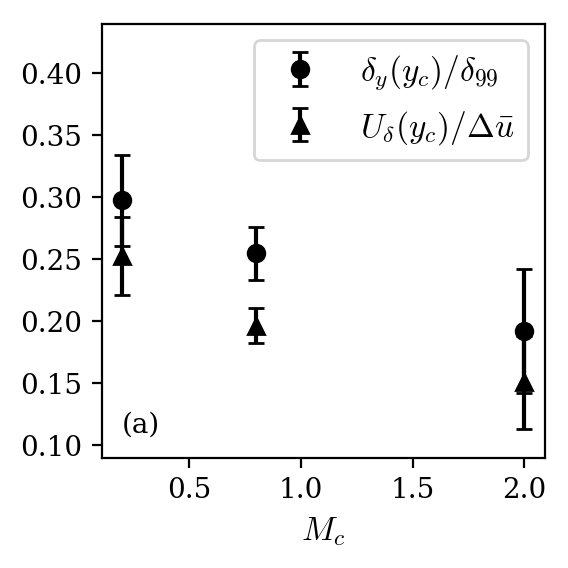

In [79]:
fig = plt.figure(figsize=(3,3),dpi=200)
# plotter(dtheta_s7,r'$\dot{\delta}_{\theta}/\dot{\delta}_{\theta,inc}$','ks')
plotter(lscales_s7['v']['ly_L99'],r'$\delta_y(y_c)/\delta_{99}$','ko')
plotter(du_s7,r'$U_\delta(y_c)/\Delta\bar{u}$','k^')

plt.ylim([0.09,0.44])
plt.xlabel(r'$M_c$')
plt.tight_layout()
plt.legend(fontsize=12)
plt.annotate('(a)',(0.2,0.11),fontsize=10)

Text(0.75,2.5,'(a)')

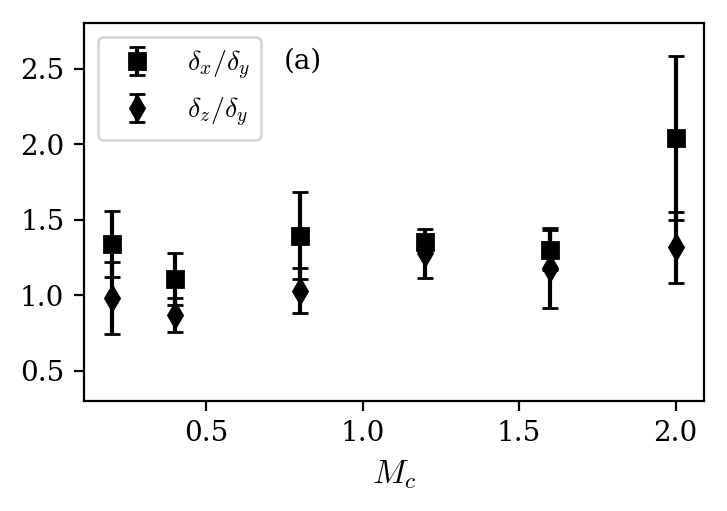

In [84]:

fig = plt.figure(figsize=(4,2.5),dpi=200)
plotter(lscales['v']['lx_ly'],'$\delta_x/\delta_y$','ks')
plotter(lscales['v']['lz_ly'],'$\delta_z/\delta_y$','kd')
plt.xlabel('$M_c$')
plt.ylim([0.3,2.8])
plt.legend(fontsize=10)
plt.annotate('(a)',(0.75,2.5),fontsize=10)

Text(0.2,0.15,'(a)')

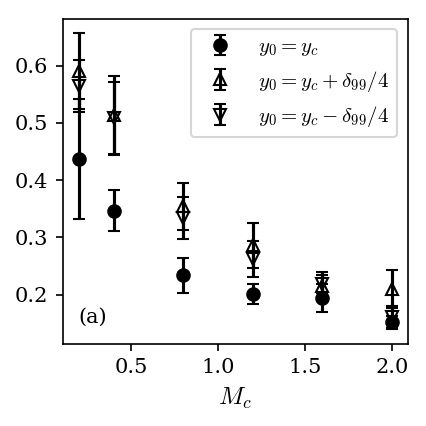

In [62]:
    
fig = plt.figure(figsize=(3,3),dpi=150)
plotter(lscales['v']['ly_L99'],r'$y_0=y_c$','ko')
plotter(lscales['v']['ly_L99_top'],r'$y_0=y_c+\delta_{99}/4$','k^',fillstyle='none')
plotter(lscales['v']['ly_L99_bot'],r'$y_0=y_c-\delta_{99}/4$','kv',fillstyle='none')

# plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$\delta_y$')

plt.tight_layout()
plt.legend(fontsize=10)
plt.annotate('(a)',(0.2,0.15),fontsize=10)

In [ ]:
cases = { 
0.2:'A1',
0.4:'B1',
0.8:'C1',
1.2:'D1',
1.6:'E1',
2.0:'F1',}

for key in sorted(du.keys()):
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(
        key,ly_L99[key][0],lx_L99[key][0],lx_ly[key][0],lz_ly[key][0],du[key][0]))